<a href="https://colab.research.google.com/github/smbonilla/learningPyTorch/blob/main/imageGenerationUsingGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Generation using Generative Adversarial Networks

In [20]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
device

'cuda'

In [22]:
!pip install jovian --upgrade -q
import jovian
jovian.__version__

'0.2.45'

In [23]:
#jovian.utils.colab.set_colab_file_id('1Bz0oJP4zOfTu3Zd2QhFAvY0EXj_119E6')

## Approach towards GAN

Random input vector -> Generator Model -> Generated Example

Generated Example + Real Example -> Discriminator Model -> Binary Classification (real/fake) -> update discriminator model + generator model 

1. train the discriminator model to distinguish between really bad generator images and real images (binary classification model)
2. train the generator model for a few epochs to create better fakes 
3. repeat 1&2 over and over




## Use Anime Face Dataset

consists of 63,000 cropped anime faces - unsupervised and so these images do not have labels


### get dataset from kaggle

use opendatasets library to download kaggle dataset
1. sign in to kaggle and click on profile picture and select my account
2. scroll down to API and click create new API Token this will download a file kaggle.json 
3. when you run `opendatasets.download` you will be asked to enter your username & kaggle API which you get from previous file

In [24]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od 

In [25]:
import os 
from pathlib import Path

DATA_DIR = './animefacedataset'
DATA_PATH = Path(DATA_DIR)

In [26]:
dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
if not DATA_PATH.is_dir():
  od.download(dataset_url)
  print(f"{DATA_PATH} doesn't exist, creating one...")
else:
  print(f"{DATA_PATH} already exists, skipping download...")

animefacedataset already exists, skipping download...


In [27]:
print(os.listdir(DATA_DIR))


['images']


In [28]:
print(os.listdir(DATA_DIR+'/images')[:10])

['21451_2008.jpg', '62567_2019.jpg', '59126_2018.jpg', '52285_2015.jpg', '6298_2003.jpg', '25802_2009.jpg', '42264_2013.jpg', '9071_2004.jpg', '43543_2013.jpg', '2244_2001.jpg']


### loading dataset

loading dataset using `ImageFolder` class from `torchvision` 
We will also resize and crop the images to 64x64
normalize all pixel values with a mean & std dev of 0.5 for each channel (will ensure that all pixel values are in the range (-1, 1)) which is more convenient for training and discriminator
create data loader to load the bathces in batches

In [29]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [30]:
imageSize = 64
batchSize = 128 
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
numWorkers = os.cpu_count()

In [31]:
transform = T.Compose([
    T.Resize(imageSize),
    T.CenterCrop(imageSize), 
    T.ToTensor(),
    T.Normalize(*stats)
])

trainData = ImageFolder(root=DATA_DIR,
                        transform=transform)

trainDataLoader = DataLoader(dataset=trainData,
                             batch_size=batchSize,
                             shuffle=True,
                             num_workers=numWorkers,
                             pin_memory=True)

create helper functions to denormalize the image tensors and display some sample images from training batch

In [32]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def denorm(imgTensors):
  """
  takes image tensors that have been normalized between -1 and 1 - returns them 
  to the range 0 and 1
  """
  return imgTensors*stats[1][0] + stats[0][0]

In [34]:
def showImages(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrows=8).permute(1, 2, 0)) # permute used to change color channels last

def showBatch(dataLoader, nmax=64):
  for images, _ in dataLoader:
    showImages(images, nmax)
    break

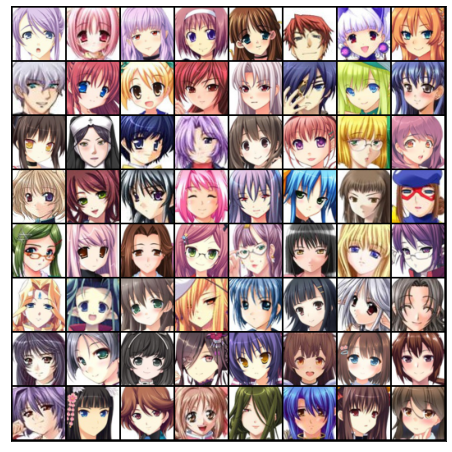

In [35]:
showBatch(trainDataLoader)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


ApiError: ignored